### Setup & Paths

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# defaults
pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

raw_data = "../data/raw/hotel_bookings.csv"
processed_data = Path("../data/processed")
FIG_DIR = Path("../reports/figs")
processed_data.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

### Load Data and basic cleaning

In [2]:
df_raw = pd.read_csv(raw_data)

# standardise column names
df_raw.columns = (
    df_raw.columns
    .str.strip()
    .str.lower()
    .str.replace(r"[^a-z0-9]+", "_", regex=True)
    .str.replace(r"^_+|_+$", "", regex=True)
)

df_raw.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015


### Dtypes, derived fields - Light Cleaning

In [3]:
df = df_raw.copy()

# parse real arrival_date
df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + "-" +
    df["arrival_date_month"].astype(str) + "-" +
    df["arrival_date_day_of_month"].astype(str),
    format="%Y-%B-%d", errors="coerce"
)

# totals / convenience fields
df["total_stay"] = df["stays_in_week_nights"] + df["stays_in_weekend_nights"]
df["total_guests"] = df[["adults","children","babies"]].fillna(0).sum(axis=1)

# month order helpers
df["month_num"] = df["arrival_date"].dt.month
df["month_short"] = df["arrival_date"].dt.strftime("%b")

# simple season
season_map = {
    12: "Summer", 1: "Summer", 2: "Summer",
    3: "Autumn", 4: "Autumn", 5: "Autumn",
    6: "Winter", 7: "Winter", 8: "Winter",
    9: "Spring", 10: "Spring", 11: "Spring"
}

df["season"] = df["month_num"].map(season_map)

# core types
int_cols = ["is_canceled","lead_time","adults","babies","is_repeated_guest",
            "previous_cancellations","previous_bookings_not_canceled",
            "booking_changes","required_car_parking_spaces","total_of_special_requests"]
for c in int_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype("int64")

num_cols = ["children","adr","stays_in_weekend_nights","stays_in_week_nights","total_stay"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# basic validity filters
df = df[df["total_guests"] > 0]              # drop zero-guest rows
df = df[df["total_stay"] > 0]                # drop zero-night stays
df = df[df["adr"] >= 0]                      # non-negative price

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118564 entries, 2 to 119389
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           118564 non-null  object        
 1   is_canceled                     118564 non-null  int64         
 2   lead_time                       118564 non-null  int64         
 3   arrival_date_year               118564 non-null  int64         
 4   arrival_date_month              118564 non-null  object        
 5   arrival_date_week_number        118564 non-null  int64         
 6   arrival_date_day_of_month       118564 non-null  int64         
 7   stays_in_weekend_nights         118564 non-null  int64         
 8   stays_in_week_nights            118564 non-null  int64         
 9   adults                          118564 non-null  int64         
 10  children                        118560 non-null  float64     

## Exploration

### Quick Sanity KPI

In [4]:
kpis = {
    "bookings": len(df),
    "cancellation_rate": df["is_canceled"].mean(),
    "avg_adr": df["adr"].mean(),
    "avg_total_stay_nights": df["total_stay"].mean(),
    "avg_lead_time_days": df["lead_time"].mean(),
}
kpis

{'bookings': 118564,
 'cancellation_rate': np.float64(0.3725920178131642),
 'avg_adr': np.float64(102.52472765763639),
 'avg_total_stay_nights': np.float64(3.444831483418238),
 'avg_lead_time_days': np.float64(104.50506899227422)}

### Excel-parity Tables

In [5]:
# bookings by hotel & year
bookings_by_hotel_year = (
    df.groupby(["hotel","arrival_date_year"])
      .size().reset_index(name="bookings")
)

# ADR by month & hotel
df["arrival_date_month"] = pd.Categorical(
    df["arrival_date_month"],
    categories=["January","February","March","April","May","June",
                "July","August","September","October","November","December"],
    ordered=True
)
adr_by_month_hotel = (
    df.groupby(["arrival_date_month","hotel"], as_index=False)["adr"].mean()
      .rename(columns={"adr":"avg_adr"})
)

# cancellation rate by market segment
cancel_by_segment = (
    df.groupby("market_segment", as_index=False)["is_canceled"].mean()
      .rename(columns={"is_canceled":"cancellation_rate"})
      .sort_values("cancellation_rate", ascending=False)
)

# avg length of stay by customer type
stay_by_customer = (
    df.groupby("customer_type", as_index=False)["total_stay"].mean()
      .rename(columns={"total_stay":"avg_total_stay"})
      .sort_values("avg_total_stay", ascending=False)
)

# save BI-ready aggregates
bookings_by_hotel_year.to_csv(processed_data / "hb_bookings_by_hotel_year.csv", index=False)
adr_by_month_hotel.to_csv(processed_data / "hb_adr_by_month_hotel.csv", index=False)
cancel_by_segment.to_csv(processed_data / "hb_cancellation_by_segment.csv", index=False)
stay_by_customer.to_csv(processed_data / "hb_stay_by_customer.csv", index=False)

# save cleaned row-level
df.to_csv(processed_data / "hb_clean_row_level.csv", index=False)

/var/folders/6q/5yldcnc578d8182d7qy9f0600000gn/T/ipykernel_89114/2476941391.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["arrival_date_month","hotel"], as_index=False)["adr"].mean()


## Visuals

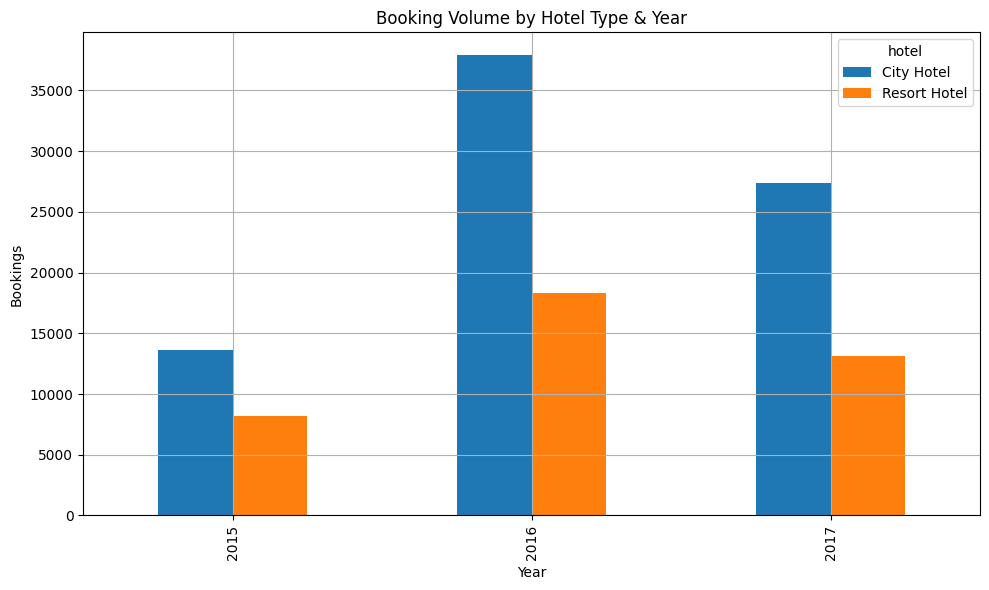

In [6]:
# Bookings by hotel & year (clustered columns)
pivot_vol = bookings_by_hotel_year.pivot(index="arrival_date_year", columns="hotel", values="bookings").fillna(0)
ax = pivot_vol.plot(kind="bar", figsize=(10,6))
ax.set_title("Booking Volume by Hotel Type & Year")
ax.set_xlabel("Year")
ax.set_ylabel("Bookings")
plt.tight_layout()
plt.savefig(FIG_DIR / "hb_vol_by_hotel_year.png", dpi=160)
plt.show()

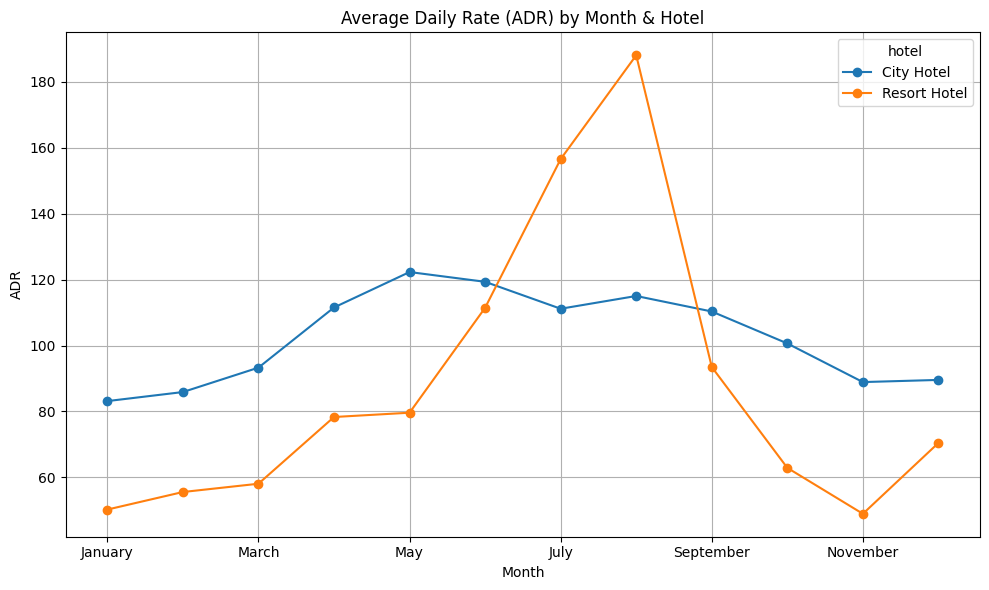

In [7]:
# ADR by month & hotel (lines)
pivot_adr = adr_by_month_hotel.pivot(index="arrival_date_month", columns="hotel", values="avg_adr").reindex(
    index=adr_by_month_hotel["arrival_date_month"].cat.categories
)
ax = pivot_adr.plot(marker="o")
ax.set_title("Average Daily Rate (ADR) by Month & Hotel")
ax.set_xlabel("Month")
ax.set_ylabel("ADR")
plt.tight_layout()
plt.savefig(FIG_DIR / "hb_adr_by_month_hotel.png", dpi=160)
plt.show()

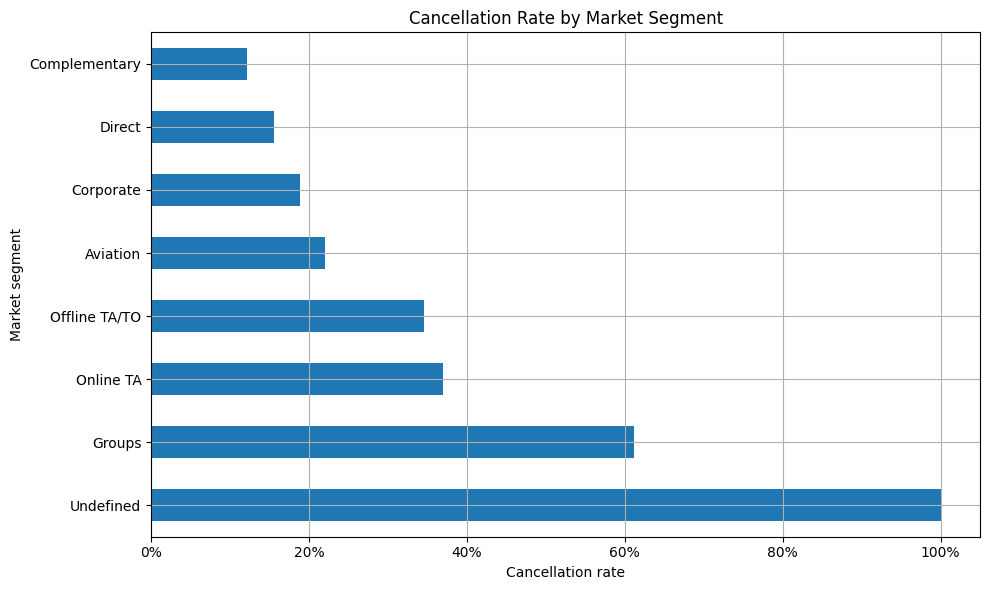

In [8]:
# Cancellation rate by market segment (horizontal bars)
ax = cancel_by_segment.plot(kind="barh", x="market_segment", y="cancellation_rate", legend=False)
ax.set_xlabel("Cancellation rate")
ax.set_ylabel("Market segment")
ax.set_title("Cancellation Rate by Market Segment")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.0%}"))
plt.tight_layout()
plt.savefig(FIG_DIR / "hb_cancel_rate_by_segment.png", dpi=160)
plt.show()

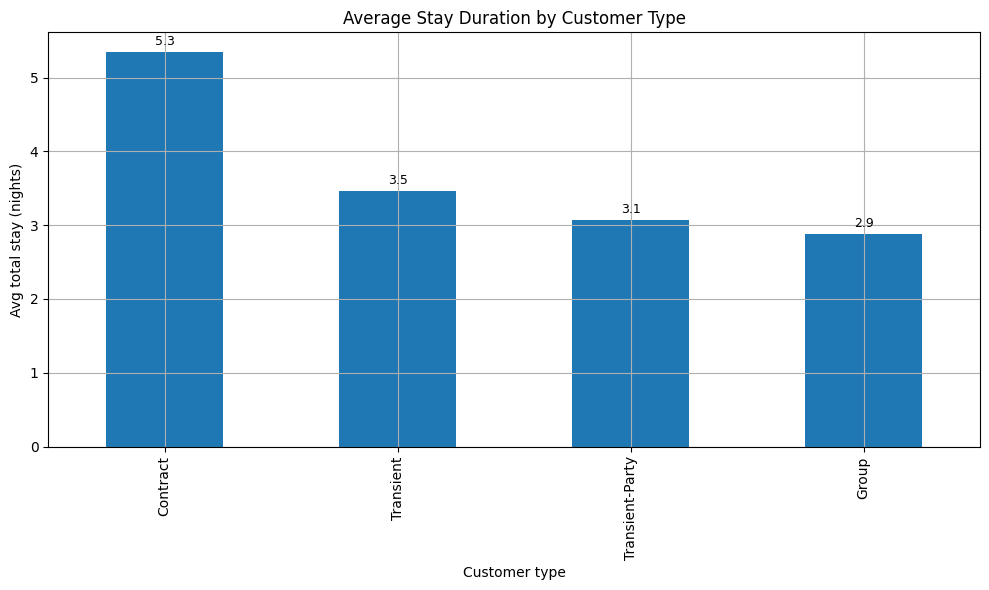

In [9]:
# Avg stay by customer type
ax = stay_by_customer.plot(kind="bar", x="customer_type", y="avg_total_stay", legend=False)
ax.set_xlabel("Customer type")
ax.set_ylabel("Avg total stay (nights)")
ax.set_title("Average Stay Duration by Customer Type")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9, xytext=(0,3), textcoords="offset points")
plt.tight_layout()
plt.savefig(FIG_DIR / "hb_avg_stay_by_customer.png", dpi=160)
plt.show()

### Python Extras

/var/folders/6q/5yldcnc578d8182d7qy9f0600000gn/T/ipykernel_89114/2045163633.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_cxl = df.groupby(lead_bins)["is_canceled"].mean().reset_index()


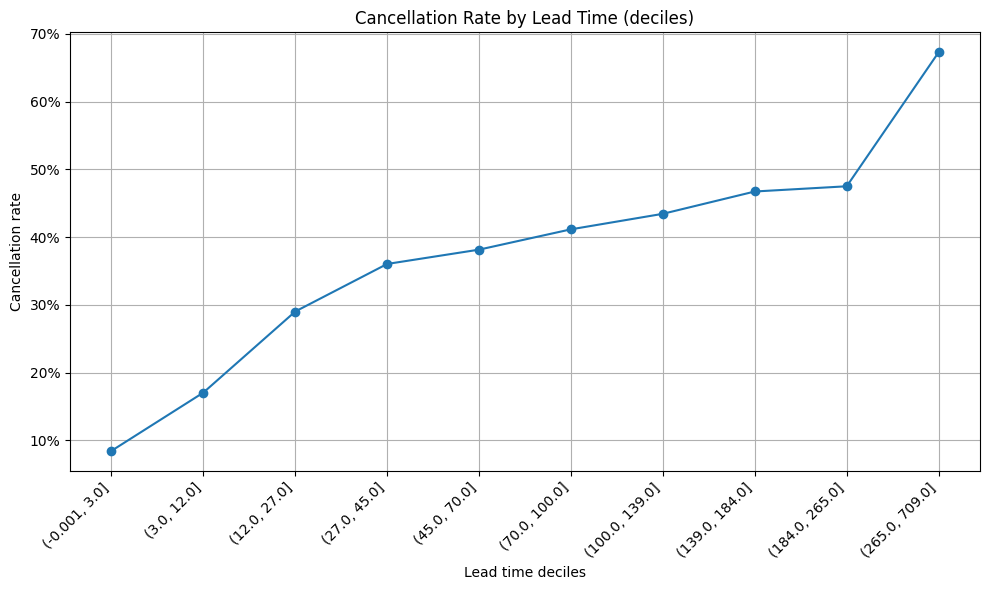

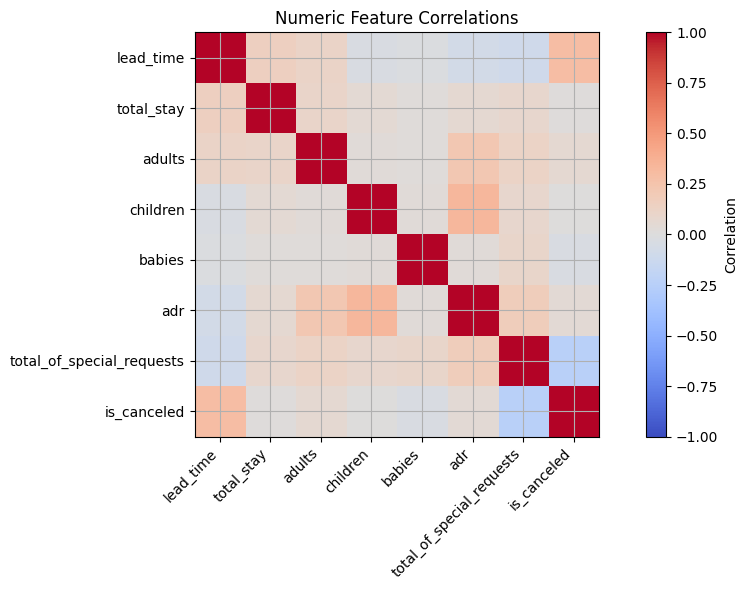

In [10]:
# Lead time vs cancellation (bin the lead_time)
cuts = np.quantile(df["lead_time"], q=np.linspace(0,1,11))
lead_bins = pd.cut(df["lead_time"], bins=np.unique(cuts), include_lowest=True)
lead_cxl = df.groupby(lead_bins)["is_canceled"].mean().reset_index()
ax = plt.gca()
plt.plot(range(len(lead_cxl)), lead_cxl["is_canceled"], marker="o")
ax.set_xticks(range(len(lead_cxl)))
ax.set_xticklabels(lead_cxl["lead_time"].astype(str), rotation=45, ha="right")
ax.set_ylabel("Cancellation rate")
ax.set_xlabel("Lead time deciles")
ax.set_title("Cancellation Rate by Lead Time (deciles)")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.0%}"))
plt.tight_layout()
plt.savefig(FIG_DIR / "hb_cancel_rate_by_leadtime.png", dpi=160)
plt.show()

# Simple correlation heatmap for numeric fields
num_for_corr = df[["lead_time","total_stay","adults","children","babies","adr","total_of_special_requests","is_canceled"]].corr()
plt.imshow(num_for_corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.xticks(range(num_for_corr.shape[1]), num_for_corr.columns, rotation=45, ha="right")
plt.yticks(range(num_for_corr.shape[0]), num_for_corr.index)
plt.title("Numeric Feature Correlations")
plt.tight_layout()
plt.savefig(FIG_DIR / "hb_corr_numeric.png", dpi=160)
plt.show()

## Machine Learning - Prediction Cancellation

In [15]:
# Prediction cancellation w/ Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, RocCurveDisplay

# features
target = "is_canceled"
numeric_features = ["lead_time","total_stay","adr","total_guests","total_of_special_requests"]
categorical_features = ["hotel","arrival_date_month","market_segment","distribution_channel",
                        "customer_type","deposit_type","is_repeated_guest"]

# drop high-cardinality or leakage columns
X = df[numeric_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)
pred_proba = clf.predict_proba(X_test)[:,1]
pred = (pred_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, pred_proba)
cm  = confusion_matrix(y_test, pred)

{"accuracy": acc, "roc_auc": auc, "confusion_matrix": cm}

{'accuracy': 0.7879644077088517,
 'roc_auc': 0.8138052272423141,
 'confusion_matrix': array([[13976,   902],
        [ 4126,  4709]])}

## Insights

### What drives Cancellation?

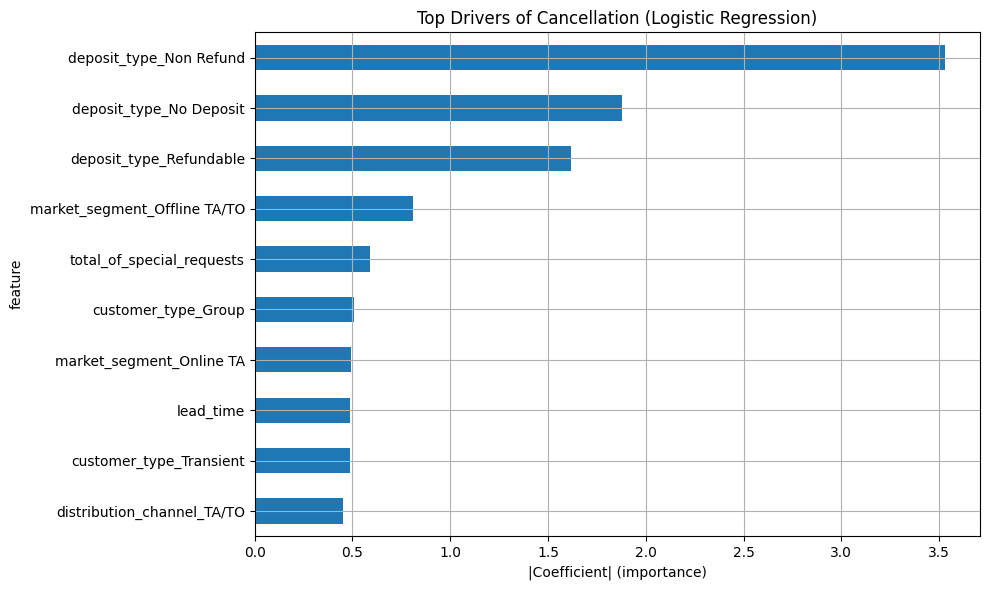

In [16]:
# extract feature names after one-hot
oh: OneHotEncoder = clf.named_steps["prep"].named_transformers_["cat"]
cat_names = oh.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_names])

coefs = clf.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": all_feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
top10 = coef_df.sort_values("abs_coef", ascending=False).head(10)

ax = top10.sort_values("abs_coef").plot(kind="barh", x="feature", y="abs_coef", legend=False)
ax.set_xlabel("|Coefficient| (importance)")
ax.set_title("Top Drivers of Cancellation (Logistic Regression)")
plt.tight_layout()
plt.savefig(FIG_DIR / "hb_top_features_logreg.png", dpi=160)
plt.show()

### ROC Curve

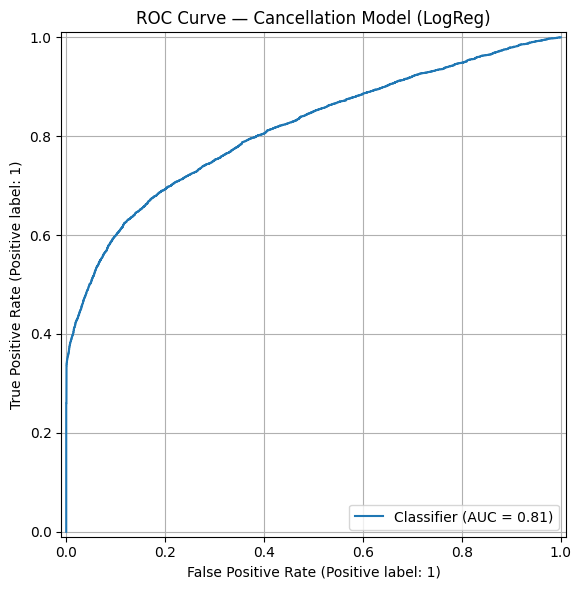

In [17]:
# ROC curve visual
RocCurveDisplay.from_predictions(y_test, pred_proba)
plt.title("ROC Curve — Cancellation Model (LogReg)")
plt.tight_layout()
plt.savefig(FIG_DIR / "hb_roc_logreg.png", dpi=160)
plt.show()

In [20]:
df["arrival_date_year"] = df["arrival_date_year"].astype(int)
df["arrival_date_month"] = df["arrival_date_month"].astype(str)

# Export BI tables for dashboards
# Save predictions joined to a small subset
pred_out = X_test.copy()
pred_out["actual_is_canceled"] = y_test.values
pred_out["pred_cancel_prob"] = pred_proba
pred_out.to_csv(processed_data / "hb_scored_sample.csv", index=False)

# Monthly KPIs (bookings, cancel rate, avg_adr)
monthly_kpis = (
    df.groupby(["arrival_date_year", "arrival_date_month"], observed=True, as_index=False)
      .agg(
          bookings=("hotel", "size"),
          cancel_rate=("is_canceled", "mean"),
          avg_adr=("adr", "mean")
      )
)

monthly_kpis.to_csv(processed_data / "hb_monthly_kpis.csv", index=False)

print("Saved processed & BI tables to:", processed_data.resolve())
print("Saved figures to:", FIG_DIR.resolve())

Saved processed & BI tables to: /Users/ranjitsapkota/Personal Files/Space Moddler/Data/Space_Utilization_and_booking_analytics/data/processed
Saved figures to: /Users/ranjitsapkota/Personal Files/Space Moddler/Data/Space_Utilization_and_booking_analytics/reports/figs
